# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [37]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [38]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [39]:
batch_size = 25
img_width = 120
img_height = 120

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [40]:
def generator(source_path, folder_list, batch_size):

#     Let's start from the 5th frame and go until the 25th frame as the initial and last frame might not contain important
#     information. Also let's take alternate of these frame. So in total we are considering (25 - 5) / 2 = 10 frames of each video
    img_idx = range(5, 26, 2)
    
    while True:
#         Shuffling the video to pick a random video, as the videos are arranged with respective to their categories
        t = np.random.permutation(folder_list)

#     There will be two batches one complete, whose size is equal to `batch_size`. Another batch will be incomplete which will
# contain all the left over images

# Processing for complete batch
        num_batches = len(t) // batch_size
        
        # we iterate over the number of batches
        for batch in range(num_batches):
            
            batch_data = np.zeros((batch_size, len(img_idx), img_width, img_height, 3))
            batch_labels = np.zeros((batch_size, 5))
            
            # iterate over the batch_size
            for folder in range(batch_size):
                
                # read all the images in the folder
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                
                #  Iterate over the frames/images of a folder to read them in
                for idx, item in enumerate(img_idx):
                    # Get the single image
                    image = imread(source_path + '/'+ t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized = resize(image, (img_width, img_height), anti_aliasing=True)
                    
                    #normalise and feed in the image
                    batch_data[folder, idx, :, :, 0] = image_resized[:, :, 0] / 255.0
                    batch_data[folder, idx, :, :, 1] = image_resized[:, :, 1] / 255.0
                    batch_data[folder, idx, :, :, 2] = image_resized[:, :, 2] / 255.0
                    
                # batch_labels are one-hot encoding of the class category
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
            
#             Processing for incomplete batch
        pending_sequence = len(t) % batch_size
        if(pending_sequence != 0):
            
            batch_data = np.zeros((pending_sequence, len(img_idx), img_width, img_height, 3))
            batch_labels = np.zeros((pending_sequence, 5))
            
            # iterate over the batch_size
            for folder in range(pending_sequence):
                
                # read all the images in the folder
                imgs = os.listdir(source_path + '/' + t[folder + (num_batches * pending_sequence)].split(';')[0])
                
                #  Iterate over the frames/images of a folder to read them in
                for idx, item in enumerate(img_idx):
                    # Get the single image
                    image = imread(source_path + '/'+ t[folder + (num_batches * pending_sequence)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized = resize(image, (img_width, img_height), anti_aliasing=True)
                    
                    #normalise and feed in the image
                    batch_data[folder, idx, :, :, 0] = image_resized[:, :, 0] / 255.0
                    batch_data[folder, idx, :, :, 1] = image_resized[:, :, 1] / 255.0
                    batch_data[folder, idx, :, :, 2] = image_resized[:, :, 2] / 255.0
                    
                # batch_labels are one-hot encoding of the class category
                batch_labels[folder, int(t[folder + (num_batches * batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        




Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [41]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, GlobalAveragePooling3D, TimeDistributed, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

In [43]:
# model = Sequential()
# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=(len(range(5, 26, 2)), img_width, img_height, 3)))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(Dropout(0.30))

# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(Dropout(0.30))

# model.add(Conv3D(128, kernel_size=(1,3,3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(Dropout(0.30))

# model.add(Conv3D(256, kernel_size=(1,3,3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(Dropout(0.30))

# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(5, activation='softmax'))

In [44]:
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=(len(range(5, 26, 2)), img_width, img_height, 3)))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())
model.add(Dropout(0.30))

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())
model.add(Dropout(0.30))

model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(Dropout(0.30))

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dropout(0.30))

model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [45]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_23 (TimeDi  (None, 11, 118, 118, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_24 (TimeDi  (None, 11, 59, 59, 32)   0         
 stributed)                                                      
                                                                 
 batch_normalization_14 (Bat  (None, 11, 59, 59, 32)   128       
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 11, 59, 59, 32)    0         
                                                                 
 time_distributed_25 (TimeDi  (None, 11, 57, 57, 64)   18496     
 stributed)                                           

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [46]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [47]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = num_epochs)

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001
)
callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [48]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [49]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
27/27 [==============================] - 62s 2s/step - loss: 1.5624 - categorical_accuracy: 0.4706 - val_loss: 1.6951 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/10
27/27 [==============================] - 60s 2s/step - loss: 0.8825 - categorical_accuracy: 0.6637 - val_loss: 1.9631 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/10
27/27 [==============================] - 58s 2s/step - loss: 0.6493 - categorical_accuracy: 0.7738 - val_loss: 1.9847 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 4/10
27/27 [==============================] - 62s 2s/step - loss: 0.4895 - categorical_accuracy: 0.8431 - val_loss: 1.9241 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 5/10
27/27 [==============================] - ETA: 0s - loss: 0.3965 - categorical_accuracy: 0.8733
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
27/27 [==============================] - 59s 2s/step - loss: 0.3965 - categorical_accuracy: 0.8733 - val_l

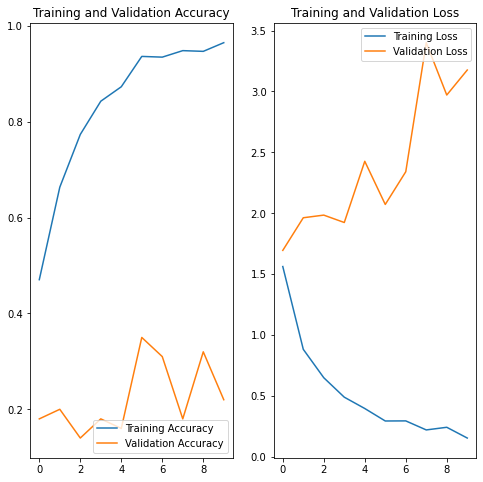

In [50]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()